In [1]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')
%load_ext autoreload
%autoreload 2

In [2]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from common.processor.utils import Utils
from common.extractor.alpaca_extractor import AlpacaExtractor
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.kpi import KPI
from financial_common.metric.metric import Metric
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
from financial_common.risk.risk_type import RiskType
from financial_common.indicator.indicator import Indicator
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats.mstats import winsorize

In [3]:
## Import standard packages
from datetime import timedelta, datetime, timezone
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [4]:
market = ADatabase("market")
fred = ADatabase("fred")
orivault = ADatabase("ori")

In [5]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("index")
market.disconnect()

In [6]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [7]:
rolling_window = 10
market.connect()
prices = []
skips = 1
model_end = 2021
backtest_end = 2025
for ticker in tqdm(index["ticker"][::skips]): 
    try:
        price = market.query("prices", {"ticker": ticker})
        if price.index.size > 150 and ticker[-1] != "W" and ".WS" not in ticker:
            price = p.lower_column(price)
            price = p.utc_date(price)
            price = p.additional_date_columns(price)
            price = price[(price["date"]>=datetime(model_end-1,10,31,tzinfo=timezone.utc)-timedelta(days=rolling_window*2)) & (price["year"]<backtest_end)]
            price.sort_values("date", inplace=True)
            price["dividend"] = 0
            price["coefficient_of_variation"] = 1
            price = Metric.MARKETCAP.calculate(price,timeframe=rolling_window,live=False)
            price = Metric.STANDARD_DEV.calculate(price,timeframe=rolling_window)
            price = Metric.NEXT_CLOSE.calculate(price,timeframe=rolling_window)
            price = Metric.NEXT_OPEN.calculate(price,timeframe=rolling_window)
            for member in Indicator:
                price = member.calculate(price,timeframe=rolling_window,live=False)
            prices.append(price.dropna())
    except Exception as e:
        print(str(e))
        continue
market.disconnect()
simulation = pd.concat(prices)

100%|███████████████████████████████████████████████████████| 11273/11273 [06:24<00:00, 29.33it/s]


In [8]:
simulation["market_cap"].mean()

np.float64(66130278.309315786)

In [9]:
min_price = .01
max_price = 1
min_cap = 1000000
max_cap = 10000000
sim = simulation[simulation["adjclose"] >= min_price].copy()
sim = sim[sim["adjclose"] <= max_price]
sim = sim[sim["market_cap"] >= min_cap]
sim = sim[sim["market_cap"] <= max_cap]

In [10]:
analysis = []
for member in tqdm(Indicator):
    if member.label != "optimal":
        for ascending in [True,False]:
            for closing in ["next_open","next_close"]:
                trades = sim.sort_values(member.label,ascending=ascending).groupby("date").first().reset_index().sort_values("date")
                trades["return"] = trades[closing]/trades["adjclose"]
                trades["pnl"] = trades["return"].cumprod()
                analysis.append({
                    "metric":member.label,
                    "ascending":ascending,
                    "closing":closing,
                    "pnl":trades["pnl"].tail(1).item(),
                    "std":trades["pnl"].std()
                })

100%|█████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 34.85it/s]


In [11]:
a = pd.DataFrame(analysis)

In [12]:
a.sort_values("pnl",ascending=False).head(5)

,metric,ascending,closing,pnl,std
23,momentum,False,next_close,12586.622825,8120.332527
50,volume_price,False,next_open,2160.800138,412.960345
24,roc,True,next_open,1419.417232,783.071415
52,option_price,True,next_open,1123.113334,481.396309
22,momentum,False,next_open,1077.322718,324.512683


In [13]:
top = a.sort_values("pnl",ascending=False).head(5).to_dict("records")[0]
top

{'metric': 'momentum',
 'ascending': False,
 'closing': 'next_close',
 'pnl': 12586.622824860067,
 'std': 8120.332526659476}

In [14]:
trades = sim.sort_values(top["metric"],ascending=top["ascending"]).groupby("date").head(1).reset_index().sort_values("date")
trades["return"] = trades[top["closing"]]/trades["adjclose"]
trades["pnl"] = trades["return"].cumprod()

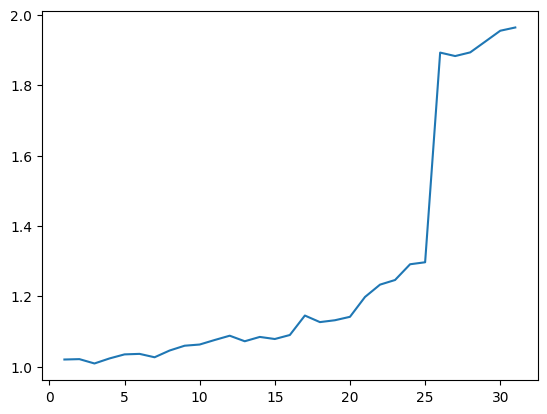

In [15]:
trades["weekday"] = trades["date"].dt.weekday
trades["month"] = trades["date"].dt.month
trades["week"] = [x.week for x in trades["date"]]
trades["month_day"] = trades["date"].dt.day

metric = "month_day"
view = trades.groupby(metric)[["return"]].mean().reset_index().sort_values(metric)
view["raw_pnl"] = view["return"].cumprod()
plt.plot(view[metric],view["raw_pnl"])
plt.show()

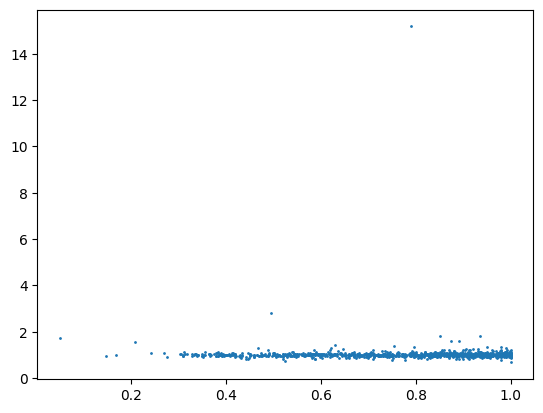

In [16]:
plt.scatter(trades["adjclose"],trades["return"],s=1)
plt.show()

In [17]:
alp = AlpacaExtractor(paper=False)
end = Utils.last_weekday(alp.clock())
start = (end - timedelta(days=rolling_window*3))
print(start,end)
## Retrieve existing stocks 
index = alp.assets().sort_values("ticker")
tickers_per_batch = int(10000/(rolling_window*4)/5)
relevant_tickers = index["ticker"]
batchs = [relevant_tickers[i:i + tickers_per_batch] for i in range(0, len(relevant_tickers), tickers_per_batch)]

2025-05-11 16:00:00-04:00 2025-06-10 16:00:00-04:00


In [18]:

prices = []
for batch in tqdm(batchs):
    try:
        tickers_data = alp.prices_bulk(batch,start,end)
        for ticker in batch:
            try:
                if ticker[-1] != "W" and ".WS" not in ticker:
                    price = tickers_data[tickers_data["ticker"] == ticker].copy()
                    price = p.lower_column(price)
                    price = p.utc_date(price)
                    price.sort_values("date", inplace=True)
                    price = p.additional_date_columns(price)
                    price["coefficient_of_variation"] = 1
                    price["dividend"] = 0
                    if price.index.size > rolling_window:
                        price = Metric.MARKETCAP.calculate(price,timeframe=rolling_window,live=True)
                        price = Indicator.indicator_type_factory(top["metric"]).calculate(price,timeframe=rolling_window,live=True)
                    prices.append(price)
            except Exception as e:
                print(str(e))
    except Exception as e:
        print(str(e))

  6%|███▍                                                        | 13/227 [00:11<02:59,  1.19it/s]

'ASIC'


 12%|███████▍                                                    | 28/227 [00:25<02:54,  1.14it/s]

'BSCZ'


 13%|███████▋                                                    | 29/227 [00:26<03:01,  1.09it/s]

'BSJX'


 40%|████████████████████████                                    | 91/227 [01:24<02:09,  1.05it/s]

'HBDC'


 41%|████████████████████████▎                                   | 92/227 [01:25<02:04,  1.09it/s]

'HGRO'


 59%|███████████████████████████████████                        | 135/227 [02:05<01:17,  1.19it/s]

'MTRA'


 78%|██████████████████████████████████████████████▎            | 178/227 [02:46<00:50,  1.03s/it]

'SCD.RTWI'


 85%|██████████████████████████████████████████████████▏        | 193/227 [03:00<00:30,  1.12it/s]

'SVA'


 93%|██████████████████████████████████████████████████████▊    | 211/227 [03:16<00:15,  1.04it/s]

'VGMS'


 94%|███████████████████████████████████████████████████████▎   | 213/227 [03:18<00:14,  1.00s/it]

'VOYG'


100%|███████████████████████████████████████████████████████████| 227/227 [03:31<00:00,  1.07it/s]


In [19]:
current_simulation = pd.concat(prices)
current_simulation.sort_values("date", inplace=True)

In [20]:
current_sim = current_simulation[current_simulation["adjclose"] >= min_price].copy()
current_sim = current_sim[current_sim["adjclose"] <= max_price]
current_sim = current_sim[current_sim["market_cap"] >= min_cap]
current_sim = current_sim[current_sim["market_cap"] <= max_cap]
recommendations = current_sim.sort_values(top["metric"],ascending=top["ascending"]).groupby("date").head(1).reset_index().sort_values("date")

In [21]:
recommendations.tail(1).to_dict("records")

[{'index': 20,
  'date': Timestamp('2025-06-10 00:00:00+0000', tz='UTC'),
  'open': 0.711,
  'adjclose': 0.6905,
  'high': 0.7246,
  'low': 0.6621,
  'volume': 3498040,
  'ticker': 'TNYA',
  'year': 2025,
  'month': 6,
  'quarter': 2,
  'week': 24,
  'day': 161,
  'weekday': 1,
  'coefficient_of_variation': 1,
  'dividend': 0,
  'adjclose_test': 0.6854,
  'high_test': 0.7469,
  'low_test': 0.67,
  'volume_test': 6247888.0,
  'market_cap': 2415396.62,
  'momentum': 0.23670000000000002}]